<a href="https://colab.research.google.com/github/Tsyhankova/goit_python/blob/main/HW_12_tensorflow_fashion_mnist_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [56]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras import Model, layers

In [57]:
from sklearn.model_selection import train_test_split
from sklearn import  metrics

from keras.applications.vgg16 import VGG16
from keras import optimizers

In [58]:
from tensorflow.keras.datasets import fashion_mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [59]:
x_test.shape, x_train.shape

((10000, 28, 28), (60000, 28, 28))

In [60]:
# меняем черно-белые картинки на rgb, так как необходимо для модели vgg16
x_train=tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=3)) 
x_test=tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=3))

In [61]:
x_test.shape, x_train.shape

(TensorShape([10000, 28, 28, 3]), TensorShape([60000, 28, 28, 3]))

In [62]:
x_train=tf.image.resize_with_pad(x_train,48,48)
x_test=tf.image.resize_with_pad(x_test,48,48)

In [63]:
x_train /= 255
x_test  /= 255
x_test.shape

TensorShape([10000, 48, 48, 3])

In [64]:
# параметры сети, чтобы их было удобно менять
batch_size = 16
num_classes = 10
epochs = 5 

In [65]:
from keras.utils import np_utils

In [66]:

input_shape = (48, 48, 3)

# преобразование отклика в 10 бинарных перменных 
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [67]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape = input_shape)
conv_base.trainable = False

In [68]:
model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(128, activation="relu"),
   layers.Dropout(0.5),
   layers.Dense(num_classes, activation='softmax'),
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


In [70]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', accuracy[1])


Epoch 1/5
3750/3750 [==============================] - 104s 25ms/step - loss: 0.5914 - accuracy: 0.7914 - val_loss: 0.4314 - val_accuracy: 0.8401
Epoch 2/5
3750/3750 [==============================] - 84s 22ms/step - loss: 0.4518 - accuracy: 0.8355 - val_loss: 0.4024 - val_accuracy: 0.8501
Epoch 3/5
3750/3750 [==============================] - 89s 24ms/step - loss: 0.4216 - accuracy: 0.8471 - val_loss: 0.3812 - val_accuracy: 0.8596
Epoch 4/5
3750/3750 [==============================] - 98s 26ms/step - loss: 0.4065 - accuracy: 0.8518 - val_loss: 0.3733 - val_accuracy: 0.8628
Epoch 5/5
3750/3750 [==============================] - 85s 23ms/step - loss: 0.3904 - accuracy: 0.8567 - val_loss: 0.3669 - val_accuracy: 0.8655
Test accuracy: 0.8654999732971191


# Попробуем дообучить, полученную сеть, разблокировав несколько (3х) слоев в conv_base

In [71]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [72]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape = input_shape)

In [83]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model_vgg16 = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dropout(0.5),
   layers.Dense(num_classes, activation='softmax'),
])

modified_model_vgg16.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [84]:
history = modified_model_vgg16.fit(x_train, y_train, batch_size=32, steps_per_epoch=100,
    epochs=100, verbose=1, validation_data=(x_test, y_test), validation_steps=50)

Epoch 1/100
100/100 [==============================] - 7s 57ms/step - loss: 1.0101 - accuracy: 0.6419 - val_loss: 0.5915 - val_accuracy: 0.7912
Epoch 2/100
100/100 [==============================] - 5s 53ms/step - loss: 0.6316 - accuracy: 0.7853 - val_loss: 0.3898 - val_accuracy: 0.8669
Epoch 3/100
100/100 [==============================] - 5s 52ms/step - loss: 0.5012 - accuracy: 0.8234 - val_loss: 0.5101 - val_accuracy: 0.8138
Epoch 4/100
100/100 [==============================] - 5s 52ms/step - loss: 0.4920 - accuracy: 0.8288 - val_loss: 0.4215 - val_accuracy: 0.8575
Epoch 5/100
100/100 [==============================] - 5s 54ms/step - loss: 0.4457 - accuracy: 0.8434 - val_loss: 0.3303 - val_accuracy: 0.8769
Epoch 6/100
100/100 [==============================] - 6s 56ms/step - loss: 0.4264 - accuracy: 0.8578 - val_loss: 0.3525 - val_accuracy: 0.8725
Epoch 7/100
100/100 [==============================] - 5s 52ms/step - loss: 0.4224 - accuracy: 0.8662 - val_loss: 0.4131 - val_accuracy:

In [85]:
accuracy = modified_model_vgg16.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', accuracy[1])

Test accuracy: 0.9165999889373779


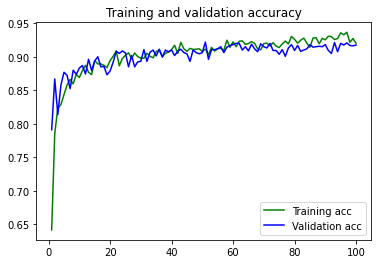

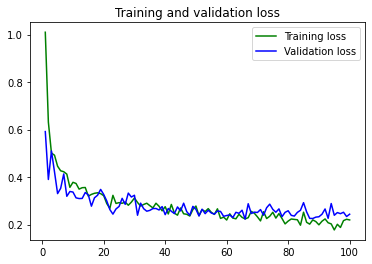

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

CNN больше подходит для задач распознавания образов, чем MLP, что видно из https://github.com/Tsyhankova/goit_python/blob/main/HW_10_tensorflow_fashion_mnist_MLP.ipynb, а также https://github.com/Tsyhankova/goit_python/blob/main/HW_11_tensorflow_fashion_mnist_conv.ipynb. 
Можно использовать готовые сети такие как VGG16, но и самостоятельно обучить с нуля. 